<a href="https://colab.research.google.com/github/erichsiao1106/models/blob/master/keras_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Input, Activation, Conv2D, MaxPool2D
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

num_classes = 10
IMG_SIZE = 32

Using TensorFlow backend.


In [ ]:
# Prepare Data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


47486
[0]


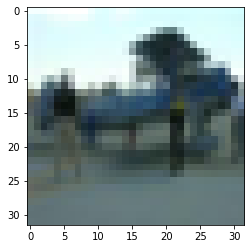

In [ ]:
index = np.random.randint(x_train.shape[0])
print(index)
img, label = x_train[index], y_train[index]
print(label)
plt.imshow(img)

In [ ]:
# normalization 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# one hot
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50000, 32, 32, 3), (10000, 32, 32, 3), (50000, 10), (10000, 10))

In [ ]:
# 1
inputs = Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = Conv2D(32, 3, padding='same', activation='relu')(x)
x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dense(128, activation='relu')(x)
prediction = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=prediction)

In [ ]:
# https://keras.io/applications/
# model = keras.applications.vgg16.VGG16(include_top=True, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=num_classes, pooling='avg')
base_model = keras.applications.mobilenet.MobileNet(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=num_classes)
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(base_model.input, predictions)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '



17227776/17225924 [==============================] - 1s 0us/step


In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 33, 33, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 16, 16, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 16, 16, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 16, 16, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 16, 16, 32)        128 

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adamax(),
              metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

checkpoint = ModelCheckpoint('ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                             monitor='val_loss', 
                             save_weights_only=False, 
                             save_best_only=True, 
                             period=1)
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_loss', 
                             save_weights_only=False, 
                             save_best_only=True, 
                             period=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, min_lr=1e-6)

logs = model.fit(x_train, y_train,
                batch_size=64,
                epochs=1000,
                verbose=1,
                callbacks=[early_stopping, reduce_lr, checkpoint],
                validation_data=(x_test, y_test))

Train on 50000 samples, validate on 10000 samples
Epoch 1/1000
50000/50000 [==============================] - 27s 536us/step - loss: 1.1083 - acc: 0.6401 - val_loss: 0.7976 - val_acc: 0.7312
Epoch 2/1000
50000/50000 [==============================] - 23s 459us/step - loss: 0.7126 - acc: 0.7612 - val_loss: 0.7663 - val_acc: 0.7413
Epoch 3/1000
50000/50000 [==============================] - 23s 459us/step - loss: 0.6108 - acc: 0.7959 - val_loss: 0.6696 - val_acc: 0.7764
Epoch 4/1000
50000/50000 [==============================] - 23s 456us/step - loss: 0.5211 - acc: 0.8257 - val_loss: 0.6541 - val_acc: 0.7915
Epoch 5/1000
 6720/50000 [===>..........................] - ETA: 18s - loss: 0.3993 - acc: 0.8653

KeyboardInterrupt: ignored

In [ ]:
# metrics

from sklearn.metrics import classification_report, confusion_matrix
y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
print(y_true.shape, y_pred.shape)
target_names = ['airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck']
print(classification_report(y_true, y_pred, target_names=target_names))
print(confusion_matrix(y_true, y_pred))


(10000,) (10000,)
              precision    recall  f1-score   support

    airplane       0.84      0.82      0.83      1000
  automobile       0.83      0.94      0.88      1000
        bird       0.73      0.74      0.74      1000
         cat       0.57      0.74      0.65      1000
        deer       0.87      0.64      0.74      1000
         dog       0.63      0.74      0.68      1000
        frog       0.83      0.85      0.84      1000
       horse       0.89      0.78      0.83      1000
        ship       0.91      0.83      0.87      1000
       truck       0.93      0.81      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

[[821  29  40  27   5   3  10   6  39  20]
 [  7 935   2   6   1   6   8   3   6  26]
 [ 41   2 742  53  33  69  44  11   2   3]
 [ 11   2  35 741  14 143  40   8   4   2]
 [ 21   1  88  71 642  86  41  46   3   1]
 [  5   